## Attempt to sonify flow of syrian refugees
* Data from UN : http://popstats.unhcr.org/en/asylum_seekers_monthly
* Original code (https://github.com/cirlabs/miditime/blob/master/README.md) transforms the magnitude of an event to the pitch and assumes one data point per event.
* Our data is monthly aggregates. So the magnitude (m) needs to translate to the number of notes (n), rather than mapping m -> pitch (p). 
* Otherwise, it will just sound like a steady stream of beeps, with varying pitch if the month has higher/lower number of refugees, but it's hard for the reader to picture.

In [1]:
# My usual setup
%matplotlib inline
import matplotlib.pyplot as plt
import pandas 
from datetime import datetime
import seaborn as sns
import glob
from os.path import basename
sns.set_context('poster') 

In [2]:
# miditime libs
from miditime.miditime import MIDITime 
import numpy as np

## Preprocess data 
* group by month and year (multiple entries per country of origin and even several for each then)
* convert data type
* MAKE SURE SORTED

In [3]:
df = pandas.read_csv('../data/SYRIA-unhcr_popstats_export_asylum_seekers_monthly_2010-2017-06.csv', skiprows=2)

In [4]:
df.head()

,Country / territory of asylum/residence,Origin,Year,Month,Value
0,Hungary,Syrian Arab Rep.,2010,January,2
1,Hungary,Syrian Arab Rep.,2010,February,3
2,Hungary,Syrian Arab Rep.,2010,March,1
3,Hungary,Syrian Arab Rep.,2010,April,3
4,Hungary,Syrian Arab Rep.,2010,June,2


In [5]:
#convert to numeric
df['value_numeric'] = pandas.to_numeric(df.Value, errors="coerce")

In [6]:
# not sure why i have to apply first to convert to string, but here we are.
df['datetime'] = pandas.to_datetime(df.apply(lambda x: str(x['Year']) + x['Month'], axis=1), format="%Y%B")

In [7]:
# There are several records per country per month, get lump sum of each month
monthly_totals = df.groupby('datetime').value_numeric.sum()

In [8]:
monthly_totals.head()

datetime
2010-01-01    499.0
2010-02-01    635.0
2010-03-01    519.0
2010-04-01    433.0
2010-05-01    472.0
Name: value_numeric, dtype: float64

In [9]:
len(monthly_totals.index)

91

In [10]:
MIN = monthly_totals.min()
MAX = monthly_totals.max()

In [11]:
print(MIN)
print(MAX)

433.0
102089.0


In [12]:
monthly_totals = monthly_totals.sort_index()

In [13]:
monthly_totals = monthly_totals.to_frame(name="magnitude")

## Save monthly totals — for easy lookup, then re-read as a dataframe. 
You can skip this step, this is for data documenting. It's also a hack to make a nice df.

In [14]:
monthly_totals.to_csv('../data/monthly-totals-syria.csv')

In [15]:
df = pandas.read_csv('../data/monthly-totals-syria.csv', parse_dates=['datetime'])

In [16]:
df.head()

,datetime,magnitude
0,2010-01-01,499.0
1,2010-02-01,635.0
2,2010-03-01,519.0
3,2010-04-01,433.0
4,2010-05-01,472.0


### Chart data

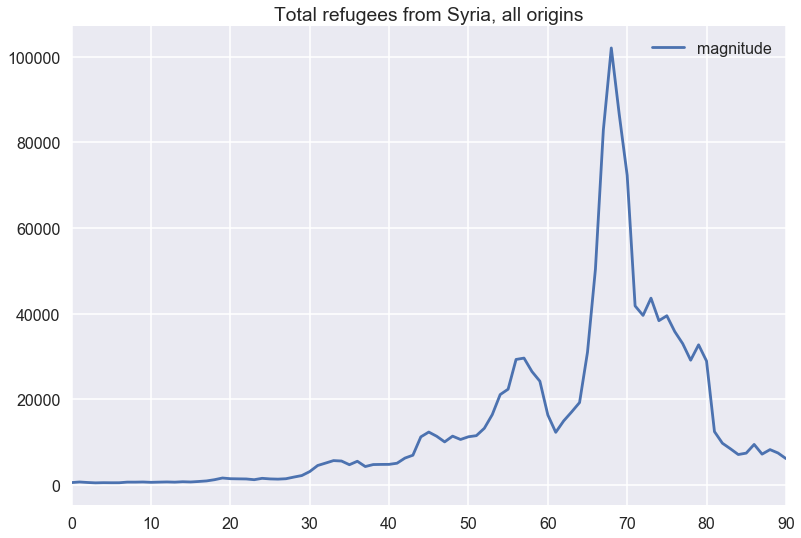

In [17]:
df[['datetime','magnitude']].plot()
plt.title("Total refugees from Syria, all origins")

## Process for MIDI
* CHANGES FROM REVEAL CODE: DO EVERYTHING IN A DF

Instantiate the class with a tempo (120bpm is the default), an output file destination, the number of seconds you want to represent a year in the final song (default is 5 sec/year), the base octave (C5 is middle C, so the default is 5, and how many octaves you want your output to range over (default is 1).

In [18]:
BPM = 440
FILENAME = '../audio/syria-2010-2017-FREQ.mid'
SEC_PER_YEAR = 6
BASE_OCTAVE = 5
OCTAVES = 1

mymidi = MIDITime(BPM,FILENAME, SEC_PER_YEAR, BASE_OCTAVE, OCTAVES)

I save this is as a column, and zip all data later, for easy error checking.
Convert your date/time data into an integer, like days since the epoch (Jan. 1, 1970). You can use the days_since_epoch() helper method, or not:

In [19]:
df['epoched'] = df.datetime.apply(lambda x: mymidi.days_since_epoch(x))

Convert your integer date/time to something reasonable for a song. For example, at 120 beats per minute, you'll need to scale the data down a lot to avoid a very long song if your data spans years. This uses the seconds_per_year attribute you set at the top, so if your date is converted to something other than days you may need to do your own conversion. But if your dataset spans years and your dates are in days (with fractions is fine), use the beat() helper method.

In [20]:
df['beat'] = df['epoched'].apply(lambda x: mymidi.beat(x))

In [21]:
START_TIME = df.beat.min() # beat doesn't start at 0 since we scaled our epoch seconds, so we just start at the first one.
print(START_TIME)

1760.0


Set up some functions to scale your other variable (magnitude in our case) to match your desired mode/key and octave range. There are helper methods to assist this scaling, very similar to a charting library like D3. You can choose a linear or logarithmic scale.

## Calculate N, the number of beats we want for a given month, as a function of magnitude.
We use numpy linear interpolation to map. (maybe add logarithmic later.) We don't need to reverse it, because higher number of refugees = more notes.

In [22]:
MIN_N = 1 # how many notes do we want per month min?
MAX_N = 100 # how many notes do we want per month max?

df['N'] = df.magnitude.apply(lambda x: np.interp(x, [MIN,MAX], [MIN_N, MAX_N]))

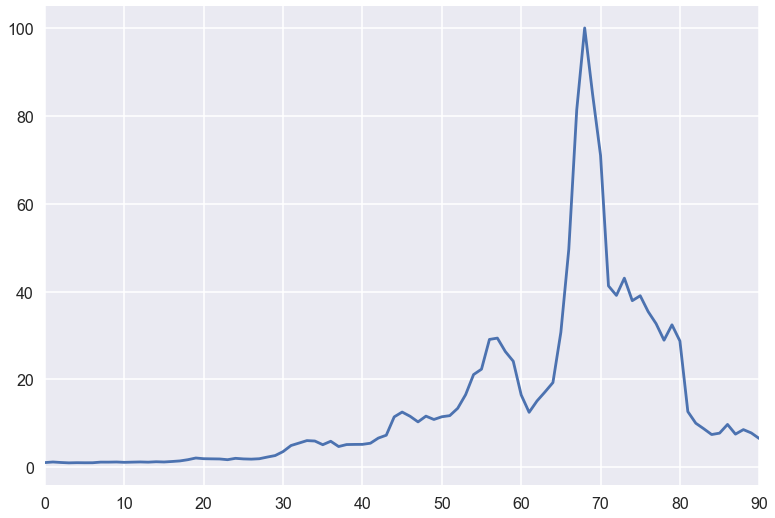

In [23]:
df.head() 
df.N.plot()

## Time to make the note list!
* I know you're not supposed to iterate through a dataframe — but it's pretty small and manegable.
* [BEAT, PITCH, VELOCITY (VOLUME), DURATION_OF_NOTE]


In [24]:
months = df.to_dict('records')

In [25]:
df.N

0       1.064276
1       1.196722
2       1.083753
3       1.000000
4       1.037981
5       1.021425
6       1.025321
7       1.166532
8       1.164584
9       1.195748
10      1.120760
11      1.166532
12      1.206461
13      1.158741
14      1.252233
15      1.199644
16      1.310665
17      1.440190
18      1.717744
19      2.102424
20      1.945630
21      1.913493
22      1.886224
23      1.719692
24      2.030357
25      1.897911
26      1.846295
27      1.937839
28      2.313754
29      2.662401
         ...    
61     12.505332
62     15.103624
63     17.141939
64     19.281538
65     30.732333
66     49.639097
67     81.352286
68    100.000000
69     84.881601
70     71.007811
71     41.280347
72     39.120298
73     43.047926
74     37.922434
75     39.038493
76     35.427373
77     32.684947
78     28.922877
79     32.422002
80     28.732972
81     12.666995
82     10.024878
83      8.772478
84      7.448011
85      7.767441
86      9.743429
87      7.539555
88      8.5669

In [26]:
note_list = [] 
P = 71 # for now constant
V = 100

for i in range(len(months)-1):
    start_beat = months[i]['beat']
    end_beat = months[i+1]['beat']
    period = end_beat - start_beat
    N = round(months[i]['N']) # truncate the N to nearest int
    
    for n in range(N):  
        #print(N)
        beat = start_beat + (n * period)
        pitch = P 
        velocity = V
        duration = (period / N) - (period/1000)  # do a little offset?
        note_list.append([beat - START_TIME, pitch, velocity, duration])
    

In [27]:
note_list

[[0.0, 71, 100, 3.726270000000018],
 [3.7300000000000182, 71, 100, 3.376619999999882],
 [7.1099999999999, 71, 100, 3.726270000000018],
 [10.839999999999918, 71, 100, 3.616380000000118],
 [14.460000000000036, 71, 100, 3.726270000000018],
 [18.190000000000055, 71, 100, 3.6063899999999],
 [21.799999999999955, 71, 100, 3.736260000000009],
 [25.539999999999964, 71, 100, 3.726270000000018],
 [29.269999999999982, 71, 100, 3.616380000000118],
 [32.8900000000001, 71, 100, 3.726269999999791],
 [36.619999999999891, 71, 100, 3.616380000000118],
 [40.240000000000009, 71, 100, 3.726270000000018],
 [43.970000000000027, 71, 100, 3.726270000000018],
 [47.700000000000045, 71, 100, 3.376619999999882],
 [51.079999999999927, 71, 100, 3.726270000000018],
 [54.809999999999945, 71, 100, 3.616380000000118],
 [58.430000000000064, 71, 100, 3.726270000000018],
 [62.160000000000082, 71, 100, 3.6063899999999],
 [65.769999999999982, 71, 100, 1.8662600000000045],
 [69.509999999999991, 71, 100, 1.8662600000000045],
 [

In [28]:
len(note_list)


1331

## Make MIDI file

In [29]:
# Add a track with those notes
mymidi.add_track(note_list)

# Output the .mid file
mymidi.save_midi()

71 0.0 3.726270000000018 100
71 3.73 3.376619999999882 100
71 7.11 3.726270000000018 100
71 10.84 3.616380000000118 100
71 14.46 3.726270000000018 100
71 18.19 3.6063899999999 100
71 21.8 3.736260000000009 100
71 25.54 3.726270000000018 100
71 29.27 3.616380000000118 100
71 32.89 3.726269999999791 100
71 36.62 3.616380000000118 100
71 40.24 3.726270000000018 100
71 43.97 3.726270000000018 100
71 47.7 3.376619999999882 100
71 51.08 3.726270000000018 100
71 54.81 3.616380000000118 100
71 58.43 3.726270000000018 100
71 62.16 3.6063899999999 100
71 65.77 1.8662600000000045 100
71 69.51 1.8662600000000045 100
71 69.51 1.861270000000009 100
71 73.24 1.861270000000009 100
71 73.24 1.8063799999999455 100
71 76.86 1.8063799999999455 100
71 76.86 1.861270000000009 100
71 80.59 1.861270000000009 100
71 80.59 1.806380000000059 100
71 84.21 1.806380000000059 100
71 84.21 1.861270000000009 100
71 87.94 1.861270000000009 100
71 87.94 1.861270000000009 100
71 91.67 1.861270000000009 100
71 91.67 1.746

71 275.92 0.22939500000000113 100
71 223.7 0.256619999999991 100
71 227.08 0.256619999999991 100
71 230.46 0.256619999999991 100
71 233.84 0.256619999999991 100
71 237.22 0.256619999999991 100
71 240.6 0.256619999999991 100
71 243.98 0.256619999999991 100
71 247.36 0.256619999999991 100
71 250.74 0.256619999999991 100
71 254.12 0.256619999999991 100
71 257.5 0.256619999999991 100
71 260.88 0.256619999999991 100
71 264.26 0.256619999999991 100
71 227.08 0.24493666666666786 100
71 230.81 0.24493666666666786 100
71 234.54 0.24493666666666786 100
71 238.27 0.24493666666666786 100
71 242.0 0.24493666666666786 100
71 245.73 0.24493666666666786 100
71 249.46 0.24493666666666786 100
71 253.19 0.24493666666666786 100
71 256.92 0.24493666666666786 100
71 260.65 0.24493666666666786 100
71 264.38 0.24493666666666786 100
71 268.11 0.24493666666666786 100
71 271.84 0.24493666666666786 100
71 275.57 0.24493666666666786 100
71 279.3 0.24493666666666786 100
71 230.81 0.20932117647059506 100
71 234.43 0

71 361.78 0.08920051282051014 100
71 365.4 0.08920051282051014 100
71 369.02 0.08920051282051014 100
71 372.64 0.08920051282051014 100
71 376.26 0.08920051282051014 100
71 379.88 0.08920051282051014 100
71 383.5 0.08920051282051014 100
71 387.12 0.08920051282051014 100
71 390.74 0.08920051282051014 100
71 394.36 0.08920051282051014 100
71 397.98 0.08920051282051014 100
71 401.6 0.08920051282051014 100
71 405.22 0.08920051282051014 100
71 408.84 0.08920051282051014 100
71 412.46 0.08920051282051014 100
71 278.52 0.10284142857142908 100
71 282.25 0.10284142857142908 100
71 285.98 0.10284142857142908 100
71 289.71 0.10284142857142908 100
71 293.44 0.10284142857142908 100
71 297.17 0.10284142857142908 100
71 300.9 0.10284142857142908 100
71 304.63 0.10284142857142908 100
71 308.36 0.10284142857142908 100
71 312.09 0.10284142857142908 100
71 315.82 0.10284142857142908 100
71 319.55 0.10284142857142908 100
71 323.28 0.10284142857142908 100
71 327.01 0.10284142857142908 100
71 330.74 0.102841

In [30]:
int(1.99)

1

In [31]:
type(round(1.99))

int